<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_5_FCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook will show you how to turn a fully connected snntorch network into its equivalent in fugu that can then beexecuted with the same / similar accuracy.
Fugu does not nativel y

In [1]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

# Setting up the Static MNIST Dataset

In [2]:
# dataloader arguments
batch_size = 128
data_path='/tmp/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
# Define a transform
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float())  # binarize
])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

If the above code blocks throws an error, e.g. the MNIST servers are down, then uncomment the following code instead.

In [4]:
# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True,)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

# Define the Network
The plan will be, for the sake of an example, to pass in binarized versions of the MNIST images. Each image will be passed into the model for 25 time steps per forward pass.

In [5]:
# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Temporal Dynamics
num_steps = 25
beta = 0.95

In [6]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)

The code in the `forward()` function will only be called once the input argument `x` is explicitly passed into `net`.

* `fc1` applies a linear transformation to all input pixels from the MNIST dataset;
* `lif1` integrates the weighted input over time, emitting a spike if the threshold condition is met;
* `fc2` applies a linear transformation to the output spikes of `lif1`;
* `lif2` is another spiking neuron layer, integrating the weighted spikes over time.

# Training the SNN

## Accuracy Metric
Below is a function that takes a batch of data, counts up all the spikes from each neuron (i.e., a rate code over the simulation time), and compares the index of the highest count with the actual target. If they match, then the network correctly predicted the target.

In [7]:
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(
    data, targets, epoch,
    counter, iter_counter,
        loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [8]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

The recording of the membrane potential is taken across:
* 25 time steps
* 128 samples of data
* 10 output neurons

We wish to calculate the loss at every time step, and sum these up together, as per Equation $(10)$:

A single weight update is applied to the network as follows:

Now, re-run the loss calculation and accuracy after a single iteration:

After only one iteration, the loss should have decreased and accuracy should have increased. Note how membrane potential is used to calculate the cross entropy
loss, and spike count is used for the measure of accuracy. It is also possible to use the spike count in the loss ([see Tutorial 6](https://snntorch.readthedocs.io/en/latest/tutorials/index.html))

## 7.5 Training Loop

Let's combine everything into a training loop. We will train for one epoch (though feel free to increase `num_epochs`), exposing our network to each sample of data once.

In [9]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval() 
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer(
                    data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
            counter += 1
            iter_counter +=1




Epoch 0, Iteration 0
Train Set Loss: 59.71
Test Set Loss: 52.56
Train set accuracy for a single minibatch: 45.31%
Test set accuracy for a single minibatch: 25.00%


Epoch 0, Iteration 50
Train Set Loss: 15.05
Test Set Loss: 15.78
Train set accuracy for a single minibatch: 85.16%
Test set accuracy for a single minibatch: 81.25%


Epoch 0, Iteration 100
Train Set Loss: 13.80
Test Set Loss: 11.71
Train set accuracy for a single minibatch: 86.72%
Test set accuracy for a single minibatch: 89.06%


Epoch 0, Iteration 150
Train Set Loss: 7.67
Test Set Loss: 6.65
Train set accuracy for a single minibatch: 92.97%
Test set accuracy for a single minibatch: 89.84%


Epoch 0, Iteration 200
Train Set Loss: 10.83
Test Set Loss: 9.84
Train set accuracy for a single minibatch: 89.84%
Test set accuracy for a single minibatch: 90.62%


Epoch 0, Iteration 250
Train Set Loss: 8.00
Test Set Loss: 9.27
Train set accuracy for a single minibatch: 85.94%
Test set accuracy for a single minibatch: 92.19%


Epoch 

# Results
## Plot Training/Test Loss

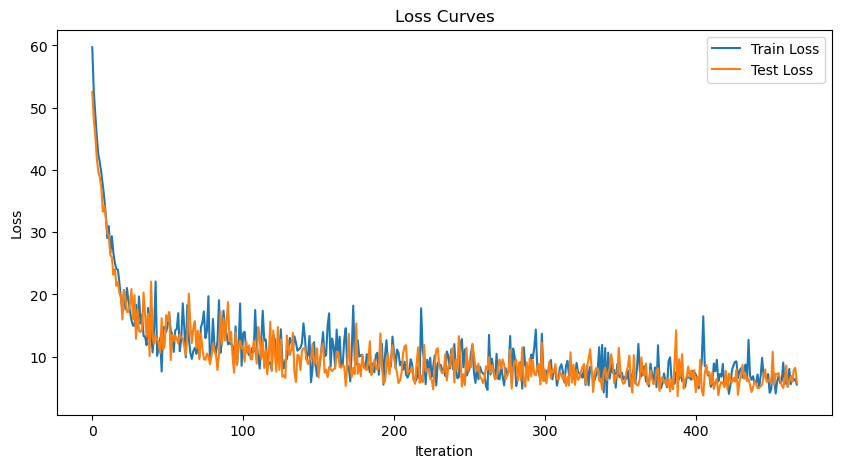

In [10]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

The loss curves are noisy because the losses are tracked at every iteration, rather than averaging across multiple iterations. 

## Test Set Accuracy
This function iterates over all minibatches to obtain a measure of accuracy over the full 10,000 samples in the test set.

In [11]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=1, shuffle=True, drop_last=False)

with torch.no_grad():
  
  net.eval()
  for data, targets in test_loader:

    data = data.to(device)
    targets = targets.to(device)
    
    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 9426/10000
Test Set Accuracy: 94.26%


Voila! That's it for static MNIST. Feel free to tweak the network parameters, hyperparameters, decay rate, using a learning rate scheduler etc. to see if you can improve the network performance. 

# Mapping trained network into fugu

In [15]:
from dev_get_torchnn_info import group_torch_layers, build_fugu_network
from dev_get_torchnn_info import get_output_neuron_numbers
# import snn_Backend
from tqdm import tqdm
from fugu.backends import snn_Backend 

test_loader_fugu = DataLoader(mnist_test, batch_size=1, shuffle=True, drop_last=False)

def frame_to_constant_spikes(x_flat, T):
    x = np.asarray(x_flat, dtype=int).reshape(784)  # binary 0/1
    return np.repeat(x[:, None], T, axis=1)        # (784, T), spike every step if 1

def set_input_and_run(spikes, num_steps, input_name):
    # spikes must match the original shape (same n_in, same T)
    backend.set_properties({
        input_name: {                      
            'spike_vector': spikes,       
            'time_dimension': True        
        }
    })

    # Clear state between samples (rebuilds neurons/synapses but DOES NOT recompile the graph)
    # TODO: is this necessary? Yes it seems so. but I am wondering if there is a better way
    backend.reset()

    # Run
    return backend.run(n_steps=num_steps)


T = num_steps  # same as your snnTorch loop length
spikes_init = np.zeros((784, T), dtype=int)

layer_dicts = group_torch_layers(net)
sc = build_fugu_network(layer_dicts, spikes_init)
input_name = sc.name_to_tag["Input"]
output_neuron_numbers = get_output_neuron_numbers(sc)

backend = snn_Backend()
backend.compile(sc, compile_args={'record':'all', 'debug_mode': False})

correct = total = 0

for data, targets in tqdm(test_loader_fugu):
    if total == 150:
         break

    # 1. Flatten the frame (batch=1, 784)
    input_data = data.view(data.size(0), -1).cpu().numpy()[0]  # shape (784,)
    target = int(targets.item())

    # 2. Same number of steps as snnTorch forward loop
    num_steps = 25   # or however many you set in the notebook

    # 3. Encode into constant spike trains
    spikes = frame_to_constant_spikes(input_data, num_steps)   # (784, T)

    # 4. Build the Fugu network from the trained snnTorch model
    result = set_input_and_run(spikes, num_steps, input_name=input_name)

    # 5. Collect output spikes
    filtered = result[result["neuron_number"].isin(output_neuron_numbers)]
    spike_counts = filtered["neuron_number"].value_counts().reindex(output_neuron_numbers, fill_value=0)
    predicted_class = int(np.argmax(spike_counts.values))

    if predicted_class == target:
        correct += 1
    total += 1

print(f'Total correctly classified test set images: {correct}/{total}')
print(f'Test Set Accuracy: {100 * correct / total:.2f}%')

  2%|▏         | 150/10000 [55:20<60:33:59, 22.14s/it]  

Total correctly classified test set images: 144/150
Test Set Accuracy: 96.00%
